# Bayesian Statistics for 2 input variables

Execute code similar to `./bayes.ipynb` for the objective function (2 variables):
### $f(x) = {x_1} \sin ({x_1}) + {x_2} \sin ({x_2}) \quad$   for ${x_1}, {x_2}$ $\varepsilon$ $[0,10]$. 

In [258]:
# import all relevant libraries
%matplotlib notebook
import numpy as np 
from math import pi
from scipy.stats import norm
from numpy.random import normal
from numpy.random import random
from numpy import vstack
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

In [259]:
# objective function
def objective(X, noise=0):
    y = (X[:,0] * np.sin(X[:,0])) + (X[:,1] * np.sin(X[:,1]))
    dy = 0.5 + 1.0 * np.random.normal(0,noise,y.shape)
    y += dy
    return y

In [261]:
x1points = np.atleast_2d(np.arange(0,10,0.5)).T
x2points = np.atleast_2d(np.arange(0,10,0.5)).T

x1mesh,x2mesh = np.meshgrid(x1points, x2points)
x1 = np.atleast_2d(x1mesh.ravel()).T
x2 = np.atleast_2d(x2mesh.ravel()).T


X = np.concatenate((x1,x2), axis=1)
X[:,1].shape
# x1.shape

(400,)

In [262]:
y = objective(X).ravel() 
ynoise = objective(X,1).ravel() 
# y.shape

<IPython.core.display.Javascript object>


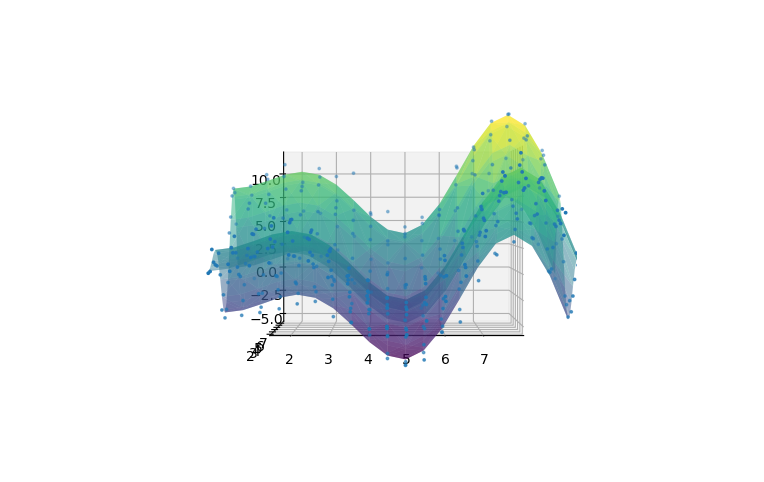

In [263]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(X[:,0].ravel(),X[:,1].ravel(),y, cmap='viridis', edgecolor='none', alpha=0.5)
ax.scatter3D(X[:,0].ravel(),X[:,1].ravel(),ynoise, s=3)

In [264]:
def fill_between_3d(ax,x1,y1,z1,x2,y2,z2,mode=1,c='steelblue',alpha=0.6):
    
    """
    
    Function similar to the matplotlib.pyplot.fill_between function but 
    for 3D plots.
       
    input:
        
        ax -> The axis where the function will plot.
        
        x1 -> 1D array. x coordinates of the first line.
        y1 -> 1D array. y coordinates of the first line.
        z1 -> 1D array. z coordinates of the first line.
        
        x2 -> 1D array. x coordinates of the second line.
        y2 -> 1D array. y coordinates of the second line.
        z2 -> 1D array. z coordinates of the second line.
    
    modes:
        mode = 1 -> Fill between the lines using the shortest distance between 
                    both. Makes a lot of single trapezoids in the diagonals 
                    between lines and then adds them into a single collection.
                    
        mode = 2 -> Uses the lines as the edges of one only 3d polygon.
           
    Other parameters (for matplotlib): 
        
        c -> the color of the polygon collection.
        alpha -> transparency of the polygon collection.
        
    """

    if mode == 1:
        
        for i in range(len(x1)-1):
            
            verts = [(x1[i],y1[i],z1[i]), (x1[i+1],y1[i+1],z1[i+1])] + \
                    [(x2[i+1],y2[i+1],z2[i+1]), (x2[i],y2[i],z2[i])]
            
            ax.add_collection3d(Poly3DCollection([verts],
                                                 alpha=alpha,
                                                 linewidths=0,
                                                 color=c))

    if mode == 2:
        
        verts = [(x1[i],y1[i],z1[i]) for i in range(len(x1))] + \
                [(x2[i],y2[i],z2[i]) for i in range(len(x2))]
                
        ax.add_collection3d(Poly3DCollection([verts],alpha=alpha,color=c))

In [365]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)
    
def plot(X, y, model, ax=None, legend=False):
    if ax is None:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
    # plot the predictions of the surrogate function across domain
    x1points = np.atleast_2d(np.linspace(0, 10, 50)).T
    x2points = np.atleast_2d(np.linspace(0, 10, 50)).T
    x1mesh, x2mesh = np.meshgrid(x1points,x2points)
    Xmesh = np.concatenate((np.atleast_2d(x1mesh.ravel()).T,np.atleast_2d(x2mesh.ravel()).T), axis=1)
    ypred, ystd = surrogate(model,Xmesh)
    ax.plot_trisurf(x1mesh.ravel(),x2mesh.ravel(), objective(Xmesh).ravel(), edgecolor='none', alpha=0.5)
    
    x1 = X[:,0]
    x2 = X[:,1]
    
    ax.plot3D(x1.ravel(),x2.ravel(), y, 'ro', markersize=10, label='Observations', mew=1, mec='k', alpha=0.7)
    ax.plot_trisurf(x1mesh.ravel(),x2mesh.ravel(), ypred, edgecolor='none', alpha=0.5)
    
#     set1 = [x1mesh.ravel(), x2mesh.ravel(), (ypred - 1.9600 * ystd)]
#     set2 = [x1mesh.ravel(), x2mesh.ravel(), (ypred + 1.9600 * ystd)]
    
#     ax.plot(*set1, lw=1, color='tab:purple', label='surrogate model 95% confidence interval')
#     ax.plot(*set2, lw=1, color='tab:purple')
#     fill_between_3d(ax, *set1, *set2, mode = 1, c='tab:purple')
#     ax.add_collection3d(pl.fill_between(x1mesh.ravel(), (ypred - 1.9600 * ystd), (ypred + 1.9600 * ystd), color='r', alpha=0.3), zs=x2mesh.ravel(), zdir='y')
#     ax.fill(np.concatenate([Xmesh, Xmesh[::-1]]),
#          np.concatenate([ypred - 1.9600 * ystd,
#                         (ypred + 1.9600 * ystd)[::-1]]),
#          alpha=.5, fc='b', ec='None', label='surrogate model 95% confidence interval')
    ax.set_xlim(0, 10)
    ax.set_xlabel('$x1$')
    ax.set_ylim(0, 10)
    ax.set_ylabel('$x2$')
    ax.set_zlabel('$f(x)$')
    ax.set_zlim(-20, 30)
    if legend:
        ax.legend(loc='upper left')

In [366]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    x1points = 10*random(50)
    x2points = 10*random(50)
    x1samples, x2samples = np.meshgrid(x1points, x2points)
    Xsamples = np.concatenate((np.atleast_2d(x1samples.ravel()).T, np.atleast_2d(x2samples.ravel()).T), axis=1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix]

<IPython.core.display.Javascript object>


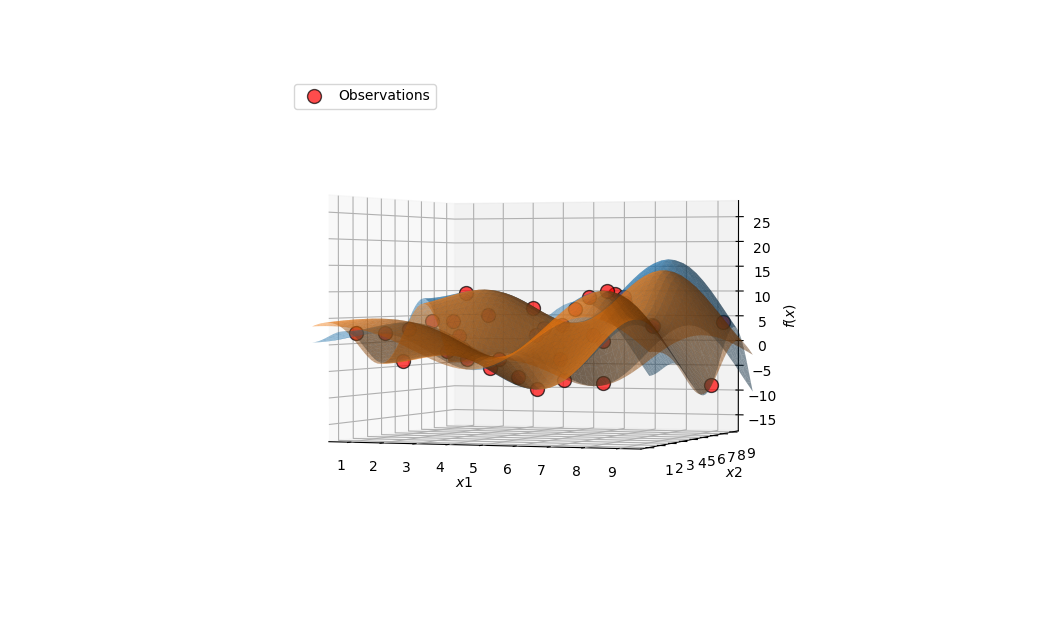

In [367]:
x1 = np.atleast_2d(10*random(36)).T
x2 = np.atleast_2d(10*random(36)).T

X = np.concatenate((x1,x2), axis=1)

y = objective(X).ravel()

kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.025)
# fit the model
gp.fit(X, y)
# plot the surrogate function
plot(X, y, gp, legend=True)

In [269]:
x = opt_acquisition(X, y, gp)
# x.shape
actual = objective(np.atleast_2d(x))
est, _ = surrogate(gp, np.atleast_2d(x))
# x.shape
print('>x=[%.3f, %.3f], f()=%3f, actual=%.3f' % (x[0],x[1], est, actual))

>x=[7.696, 2.579], f()=9.551077, actual=9.476


# Bayesian Statistics for more than 2 input variables

Execute a generalisable code similar to `./bayes.ipynb`. Use the objective function:

### $$f(x)  = \sum_{i=1}^n {x_i} \sin ({x_i}) \quad {\bf \text{for}} \;x_i \, \varepsilon \, [0,10]$$

In [369]:
# import all relevant libraries
%matplotlib notebook
import numpy as np 
from math import pi
from scipy.stats import norm
from numpy.random import normal
from numpy.random import random
from numpy import vstack
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

Let's define the problem at hand: 

We have an experimental process with input parameters $X$ = $[x_1, x_2, ... , x_n]$, and output parameter $y$.

The objective function is the actual function $f:X \rightarrow y$

The surrogate function is our tunable estimate of the objective function. This function is estimated using our existing data ($X_0$, $y_0$) and also maps like the objective function $s:X \rightarrow y$

The acquisition function is a 

In [381]:
# import csv as 2D numpy array

# file = open("sample.csv")
# numpy_array = np.loadtxt(file, delimiter=",")
# X = numpy_array[:,:-1]
# y = numpy_array[:,-1]


# ====================  OR  ====================

# Create synthetic array

x1 = np.atleast_2d(10*random(10)).T
x2 = np.atleast_2d(10*random(10)).T
x3 = np.atleast_2d(10*random(10)).T
x4 = np.atleast_2d(10*random(10)).T

X = np.concatenate((x1,x2,x3,x4), axis=1)
# X[:,:-1].shape

In [382]:
# define the objective function
def objective(X, noise=0):
    y = 0
    for i in range(X.shape[1]):
        y += (X[:,i] * np.sin(X[:,i]))
    dy = 0.5 + 1.0 * np.random.normal(0,noise,y.shape)
    y += dy
    return y

In [383]:
y = objective(X)
ynoise = objective(X,1)
xrange=np.array([[0,10],[-1,10],[0,11],[-1,11]])
# xrange.shape[0]

In [376]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

def predict(X, y, xrange, meshdensity, model):
    # add check: X.shape[1] == xrange.shape[0]
    grid = np.meshgrid(*[np.linspace(i,j,meshdensity)[:] for i,j in zip(xrange[:,0],xrange[:,1])])
    Xmesh = np.concatenate(([np.atleast_2d(grid[i].ravel()).T for i in range(X.shape[1])]), axis=1)
    ypred, ystd = surrogate(model,Xmesh)
    return ypred, ystd;
    

In [377]:
kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.025)
# fit the model
gp.fit(X, y)
# plot the surrogate function
ypred, ystd = predict(X, y, xrange, 5, gp)

In [402]:
# print(type(ypred))
# print(ypred.shape)
# print(type(ystd))
# print(ystd.shape)

meshdensity = 5
xrange=np.array([[0,10],[-1,10],[0,11],[-1,11]])
grid = np.meshgrid(*[np.linspace(i,j,meshdensity)[:] for i,j in zip(xrange[:,0],xrange[:,1])])

# Xmesh = np.concatenate(([np.atleast_2d(grid[i].ravel()).T for i in range(4)]), axis=1)
# Xmesh.shape

In [267]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    x1points = 10*random(50)
    x2points = 10*random(50)
    x1samples, x2samples = np.meshgrid(x1points, x2points)
    Xsamples = np.concatenate((np.atleast_2d(x1samples.ravel()).T, np.atleast_2d(x2samples.ravel()).T), axis=1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix]

In [ ]:
x1 = np.atleast_2d(10*random(6)).T
x2 = np.atleast_2d(10*random(6)).T

X = np.concatenate((x1,x2), axis=1)

y = objective(X).ravel()

kernels = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernels, n_restarts_optimizer=9, alpha=0.025)
# fit the model
gp.fit(X, y)
# plot the surrogate function
plot(X, y, gp, legend=True)

In [269]:
x = opt_acquisition(X, y, gp)
# x.shape
actual = objective(np.atleast_2d(x))
est, _ = surrogate(gp, np.atleast_2d(x))
# x.shape
print('>x=[%.3f, %.3f], f()=%3f, actual=%.3f' % (x[0],x[1], est, actual))

>x=[7.696, 2.579], f()=9.551077, actual=9.476
